# Balancing a Pole on a Cart

## Submission Details

This is the submission for Cholakov Kristiyan Kamenov (U2123543B). I didn't have a team, I was doing the project alone.

## Introduction

In the ever-evolving field of artificial intelligence, one of the pivotal challenges that has captured the attention of researchers and engineers alike is the inverted pendulum problem. This classic control theory task, also known as the "cart-pole" problem, provides a simplified yet relevant model for testing the efficiency and robustness of reinforcement learning algorithms. The problem draws inspiration from the real-world scenario of maintaining stability and balance in dynamic systems, such as balancing a broomstick on one's hand or a self-balancing robot.

The cart-pole system comprises a cart that moves horizontally along a track and a pole connected to the cart through a hinge at its center. The primary objective of the AI agent is to learn how to control the cart's movements by applying appropriate forces to either side, preventing the pole from falling and maintaining the system's overall balance. To accomplish this, the agent relies on continuous feedback from the environment, which typically includes information about the cart's position, velocity, and the pole's angle and angular velocity.

In this project, we will delve into the intricacies of the cart-pole problem, exploring various reinforcement learning techniques to develop an AI agent capable of effectively balancing the pole on the cart. By studying the fundamentals of control theory and reinforcement learning, we aim to gain insights into the challenges of developing adaptive and robust AI solutions for dynamic, real-world environments.

## Installing Dependencies

In [139]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Connecting to Google Drive

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
cd drive/MyDrive/NTU/SC3000

[Errno 2] No such file or directory: 'drive/MyDrive/NTU/SC3000'
/content/drive/MyDrive/NTU/SC3000


## Imports

In [144]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np 
from gym.wrappers import RecordVideo
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import glob
import io
import time, math, random
from typing import Tuple

## Function for Showing the Videos

In [145]:
# Creating a custom function to show the a video by its path in the notebook
def show_video(video_path):
    # Getting the video file by its path
    video = io.open(video_path, 'r+b').read()
    # Encoding the video
    encoded_video = base64.b64encode(video)
    # Displaying the video in the notebook
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii'))))

## The Enviroment

Below we are creating an enviroment just to show how it looks.

In [146]:
# Including the library to record the whole video, don't stop when episode ends
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# Setting the name of the video
video_name = "before_training.mp4"
# Creating the enviroment
env = gym.make("CartPole-v1")
# Starting the video for the enviroment
video = VideoRecorder(env, video_name)
# Restarting the enviroment
env.reset()
# Running 200 frames
for i in range(200):
  # Capturing a frame for the video
  video.capture_frame()
  # A function to roduce either 0 (left) or 1 (right)
  observation, reward, done, info = env.step(env.action_space.sample())

# Closing the video and the enviroment
video.close()
env.close()
# Showing the video in the notebook
show_video(before_training)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wr

## Task 1

Task 1 requires you to develop an RL agent using the OpenAI Gym library and demonstrate its correctness by sampling a random state from the cart pole environment and inputting it to the agent to get a chosen action.

### The DQN Agent

This code is an implementation of the DQN (Deep Q-Network) algorithm to train an RL (Reinforcement Learning) agent to balance the pole on a cart in the cart pole environment. The code uses the OpenAI Gym library to interact with the environment and TensorFlow to define and train a neural network model that predicts Q-values for all possible actions in a given state.

The DQN algorithm employs an epsilon-greedy policy to choose an action based on the predicted Q-values and the current value of epsilon. The code uses a replay buffer to store and sample past experiences to update the model parameters using the Bellman equation and mean squared error loss. The epsilon value is updated using a decay schedule during training.

In [147]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import layers
import time 
# The DQN model can be defined as a type of neural network that receives a state as input and produces a collection of Q-values for all feasible actions
class DQN(tf.keras.Model):
    #  The neural network architecture comprises of two fully connected layers, each containing 24 units, and a linear output layer with a number of units equivalent to the total number of actions possible
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = layers.Dense(24, activation='relu')
        self.fc2 = layers.Dense(24, activation='relu')
        self.out = layers.Dense(action_size, activation='linear')
    
    # The input is processed through the layers of the network in a way that produces the output Q-values. Specifically, the input state is passed through the first fully connected layer, then through the second fully connected layer, and finally through the linear output layer to generate the Q-values for each possible action
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x

# The epsilon-greedy policy is a reinforcement learning decision-making strategy that randomly selects an action with a probability of epsilon, or chooses the action with the highest estimated reward (represented by Q-values) otherwise
def epsilon_greedy_policy(q_values, epsilon):
    if np.random.rand() < epsilon:
        # Choose a random action with probability epsilon
        action = np.random.choice(q_values.shape[1])
    else:
        # Choose the action with the highest estimated reward
        action = np.argmax(q_values)
    return action

# Defining the DQN algorithm
def dqn(env, num_episodes, max_steps, epsilon_start, epsilon_decay, epsilon_min):
    # Retrieves the number of dimensions present in the state space of the environment
    state_size = env.observation_space.shape[0]
    # Determine the dimensionality of the state space in the environment
    action_size = env.action_space.n
    # Assign the previously defined function as the model
    model = DQN(state_size, action_size)
    # An Adam optimizer is instantiated with a learning rate of 0.001
    optimizer = tf.optimizers.Adam(learning_rate=0.001)
    # An empty list is created to store the transitions in the replay buffer
    replay_buffer = []
    # The starting value is used to initialize the epsilon value
    epsilon = epsilon_start
    # An empty list is created to accumulate the total reward obtained in each episode
    scores = []
    # An empty list is created to store the epsilon value for each episode
    eps= []
    # A loop is initiated over the designated number of episodes
    for episode in range(num_episodes):
        # The environment is reset, and the initial state is retrieved
        state = env.reset()
        total_reward = 0
        # A loop is started for the designated maximum number of steps in each episode
        for step in range(max_steps):
            # The Q-values for the current state are obtained from the model
            q_values = model(np.expand_dims(state, 0))
            # An action is chosen using the epsilon-greedy policy, which considers the Q-values and the current value of epsilon
            action = epsilon_greedy_policy(q_values.numpy(), epsilon)
            # The chosen action is executed in the environment, and the resulting next state, reward, and done flag, indicating if the episode is complete, are observed
            next_state, reward, done, _ = env.step(action)
            # The reward obtained from the current step is added to the total reward accumulated in the current episode
            total_reward += reward
            # Sum up all the score
            scores.append(total_reward)
            # The transition is saved in the replay buffer
            replay_buffer.append((state, action, reward, next_state, done))
            if len(replay_buffer) > 1000:
                replay_buffer.pop(0)
            # If there are at least 32 transitions stored in the replay buffer, the model parameters will be updated
            if len(replay_buffer) >= 32:
                # The replay buffer randomly selects 32 transitions to pick elements from an array
                samples = np.random.choice(len(replay_buffer), 32)
                states = np.array([replay_buffer[i][0] for i in samples])
                actions = np.array([replay_buffer[i][1] for i in samples])
                rewards = np.array([replay_buffer[i][2] for i in samples])
                next_states = np.array([replay_buffer[i][3] for i in samples])
                dones = np.array([replay_buffer[i][4] for i in samples])
                with tf.GradientTape() as tape:
                    # This statement refers to the computation of Q-values for all possible actions in the current state
                    q_values = model(states)
                    # This sentence describes the computation of the Q-value for the chosen action, which is accomplished through the use of one-hot encoding
                    q_values = tf.reduce_sum(q_values * tf.one_hot(actions, depth=action_size), axis=1)
                    # This sentence explains that the Bellman equation is used to calculate the target Q-values for the input states and actions
                    targets = rewards + (1.0 - dones) * 0.99 * tf.reduce_max(model(next_states), axis=1)
                    # This sentence indicates that the mean squared error is calculated between the predicted Q-values and the target Q-values 
                    loss = tf.reduce_mean(tf.square(q_values - targets))
                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
            state = next_state
            if done:
                break
        # This block of code adjusts the value of epsilon using the epsilon decay schedule, records it in the eps list, and displays the total reward and epsilon for the current episode
        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        eps.append(epsilon)
        # Print the current episode and the corresponding reward and epsilon
        print("Episode:{} -> Reward: {}, Epsilon: {}".format(episode, total_reward,epsilon))
        # Stop when the reward reaches the maximum one
        if total_reward == 500:
          break
    return model,scores,epsilon


### Training the Agent

In [ ]:
# Create enviroment and test the model
env = gym.make("CartPole-v1")
model,scores ,esp= dqn(env, num_episodes=1000, max_steps=500, epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.01)
# Save the model when a successfull state is reached
model.save("models/dqn500", save_format='tf')

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode:0 -> Reward: 9.0, Epsilon: 0.995
Episode:1 -> Reward: 14.0, Epsilon: 0.990025
Episode:2 -> Reward: 11.0, Epsilon: 0.985074875
Episode:3 -> Reward: 12.0, Epsilon: 0.9801495006250001
Episode:4 -> Reward: 29.0, Epsilon: 0.9752487531218751
Episode:5 -> Reward: 28.0, Epsilon: 0.9703725093562657
Episode:6 -> Reward: 29.0, Epsilon: 0.9655206468094844
Episode:7 -> Reward: 16.0, Epsilon: 0.960693043575437
Episode:8 -> Reward: 31.0, Epsilon: 0.9558895783575597
Episode:9 -> Reward: 20.0, Epsilon: 0.9511101304657719
Episode:10 -> Reward: 23.0, Epsilon: 0.946354579813443
Episode:11 -> Reward: 18.0, Epsilon: 0.9416228069143757
Episode:12 -> Reward: 17.0, Epsilon: 0.9369146928798039
Episode:13 -> Reward: 11.0, Epsilon: 0.9322301194154049
Episode:14 -> Reward: 48.0, Epsilon: 0.9275689688183278
Episode:15 -> Reward: 20.0, Epsilon: 0.9229311239742362
Episode:16 -> Reward: 20.0, Epsilon: 0.918316468354365
Episode:17 -> Reward: 21.0, Epsilon: 0.9137248860125932
Episode:18 -> Reward: 36.0, Epsilon:

### Showing the Training Stats

First, we have to get the data as an array of numbers, each number represents the reward for an episode.

In [148]:
# Getting the file with the saved output from the previous code cell
scores_file = open('data/dqn_scores.txt', 'r')
# Getting the lines of the file
lines = scores_file.readlines()
# Creating an array to store the scores
scores_array = []
# Manipulating the lines to get the rewards values
for line in lines:
    line_content = line.split(" ")
    scores_array.append(float(line_content[3][:-1]))
# Print the arrays
print(scores_array)

[9.0, 14.0, 11.0, 12.0, 29.0, 28.0, 29.0, 16.0, 31.0, 20.0, 23.0, 18.0, 17.0, 11.0, 48.0, 20.0, 20.0, 21.0, 36.0, 13.0, 13.0, 10.0, 11.0, 29.0, 17.0, 21.0, 15.0, 18.0, 35.0, 18.0, 19.0, 16.0, 27.0, 19.0, 13.0, 17.0, 46.0, 23.0, 15.0, 14.0, 13.0, 24.0, 25.0, 17.0, 20.0, 12.0, 14.0, 23.0, 48.0, 17.0, 25.0, 9.0, 33.0, 20.0, 12.0, 38.0, 9.0, 25.0, 10.0, 12.0, 49.0, 18.0, 19.0, 10.0, 11.0, 58.0, 35.0, 22.0, 11.0, 12.0, 22.0, 56.0, 12.0, 16.0, 58.0, 12.0, 35.0, 21.0, 14.0, 16.0, 34.0, 18.0, 23.0, 9.0, 61.0, 14.0, 26.0, 17.0, 16.0, 15.0, 31.0, 11.0, 16.0, 12.0, 20.0, 16.0, 34.0, 24.0, 53.0, 13.0, 26.0, 31.0, 37.0, 16.0, 11.0, 41.0, 19.0, 21.0, 37.0, 15.0, 17.0, 17.0, 16.0, 66.0, 27.0, 12.0, 22.0, 69.0, 14.0, 24.0, 42.0, 13.0, 85.0, 23.0, 16.0, 45.0, 28.0, 73.0, 32.0, 22.0, 17.0, 16.0, 15.0, 15.0, 41.0, 39.0, 40.0, 50.0, 41.0, 16.0, 23.0, 69.0, 46.0, 14.0, 14.0, 38.0, 101.0, 36.0, 27.0, 24.0, 14.0, 60.0, 13.0, 23.0, 31.0, 93.0, 45.0, 50.0, 69.0, 68.0, 100.0, 72.0, 82.0, 95.0, 18.0, 45.0, 105.0

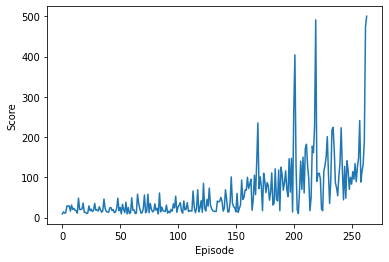

In [149]:
# Plotting the rewards of the episodes that the agent played
import matplotlib.pyplot as plt
plt.plot(scores_array)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()

### Testing Action for a Random State

Loading the model

In [150]:
# Getting the model
model = tf.saved_model.load("models/dqn500")

Creating an enviroment with a random state and getting the action from the model.

In [151]:
# Creating an enviroment
env = gym.make("CartPole-v1")
observation = env.reset()
# Running the model on this sample state
q_values = model(np.expand_dims(observation, 0))
action = epsilon_greedy_policy(q_values.numpy(), 0.01)
print("Observation:", observation)
print("Chosen action:", action)


Observation: [-0.04566394  0.01511456 -0.00750988 -0.04276762]
Chosen action: 0


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Task 2

Develop an RL agent that can effectively balance the pole on the cart in the cart pole environment. Run the agent for 100 episodes by resetting the environment at the beginning of each episode. Plot the cumulative reward against all episodes in Jupyter notebook and print the average reward over the 100 episodes. The average reward should be greater than 195.

### Testing for 100 Episodes

In [157]:
# Getting the observation from the enviroment
observation = env.reset()
current_reward = 0
total_reward = 0
rewards_list = []
for i in range(100):
  print("Episode: "+str(i))
  # Starting the enviroment for the episode
  observation = env.reset()
  while True:
      # Setting the model to do the actions
      q_values = model(np.expand_dims(observation, 0))
      action = epsilon_greedy_policy(q_values.numpy(), 0.01)
      # Getting the observation after the model's actions for the frame
      observation, reward, done, info = env.step(action)
      current_reward+=reward
      if done: 
        # Printing the reward for the current episode
        print("Reward: "+ str(current_reward) + '\n')
        rewards_list.append(current_reward)
        # Summing the current episode reward to the one of all episodes
        total_reward += current_reward
        break
  # Reseting the current award variable after the episode finishes
  current_reward = 0

# Printing the average reward
print("Avg. Reward: " + str(total_reward/100))
# Printing if the agent is good enough
print("Is my agent good enough?", end=' ')
if (total_reward/100 == 500):
  print('Perfect')
elif (total_reward/100 == 500):
  print("True")

Episode: 0
Reward: 500.0

Episode: 1
Reward: 500.0

Episode: 2
Reward: 500.0

Episode: 3
Reward: 500.0

Episode: 4
Reward: 500.0

Episode: 5
Reward: 500.0

Episode: 6
Reward: 500.0

Episode: 7
Reward: 500.0

Episode: 8
Reward: 500.0

Episode: 9
Reward: 500.0

Episode: 10
Reward: 500.0

Episode: 11
Reward: 500.0

Episode: 12
Reward: 500.0

Episode: 13
Reward: 500.0

Episode: 14
Reward: 500.0

Episode: 15
Reward: 500.0

Episode: 16
Reward: 500.0

Episode: 17
Reward: 500.0

Episode: 18
Reward: 500.0

Episode: 19
Reward: 500.0

Episode: 20
Reward: 500.0

Episode: 21
Reward: 500.0

Episode: 22
Reward: 500.0

Episode: 23
Reward: 500.0

Episode: 24
Reward: 500.0

Episode: 25
Reward: 500.0

Episode: 26
Reward: 500.0

Episode: 27
Reward: 500.0

Episode: 28
Reward: 500.0

Episode: 29
Reward: 500.0

Episode: 30
Reward: 500.0

Episode: 31
Reward: 500.0

Episode: 32
Reward: 500.0

Episode: 33
Reward: 500.0

Episode: 34
Reward: 500.0

Episode: 35
Reward: 500.0

Episode: 36
Reward: 500.0

Episode: 37

### If the Model is Good

In [158]:
# Printing the average reward
print("Avg. Reward: " + str(total_reward/100))
# Printing if the agent is good enough
print("Is my agent good enough?", end=' ')
if (total_reward/100 == 500):
  print('Perfect')
elif (total_reward/100 == 500):
  print("True")

Avg. Reward: 500.0
Is my agent good enough? Perfect


### Showing the Results from the 100 Episodes

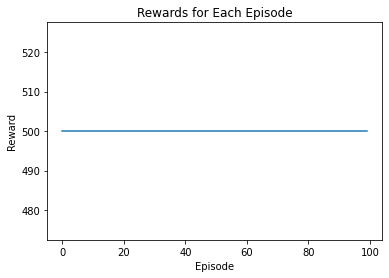

In [159]:
plt.plot(rewards_list)
plt.title("Rewards for Each Episode")
plt.ylabel("Reward")
plt.xlabel("Episode")
plt.show()

## Task 3

Render one episode played by the developed RL agent to visually inspect how well the agent is performing in the cart pole environment.

In [160]:
# Importing the library to record the video
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# Getting the model
model = tf.saved_model.load("models/dqn500")
# Setting the name of the video
video_name = "after_dqn.mp4"
# Creating an enviroment
env = gym.make("CartPole-v1")
# Starting the recording
video = VideoRecorder(env, video_name)
# Restarting the enviroment and setting the variables
observation = env.reset()
episode_reward = 0
episode_counter = 0
while True:
  # Printing the current episode
  print("Episode: "+str(episode_counter))
  observation = env.reset()
  while True:
      # Implementing the model
      q_values = model(np.expand_dims(observation, 0))
      action = epsilon_greedy_policy(q_values.numpy(), 0.01)
      # Capture a frame of the running enviroment
      video.capture_frame()
      # Getting the observation after the action of the model
      observation, reward, done, info = env.step(action)
      # Summing the current reward to the total one for the episode
      episode_reward+=reward
      # If the episode ended
      if done: 
        # Printing the reward for the episode
        print("Reward: "+ str(episode_reward))
        break
  # Increment the episode counter
  episode_counter += 1
  if(episode_reward == 500):
    # Ending the enviroment and the video
    env.close()
    video.close()
    # Showing the video
    show_video(video_name)
    break
  else:
    # Restarting the reward for the current episode
    episode_reward = 0

/usr/local/lib/python3.9/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


Episode: 0


/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Reward: 500.0


## References:



*   Python Lessons. (2019, November 26). Introduction to Reinforcement Learning - Cartpole DQN [Video]. YouTube. https://www.youtube.com/watch?v=D795oNqa-Vk
*   Kumar, S. (2020). Balancing a CartPole System with Reinforcement Learning -- A Tutorial. ArXiv (Cornell University). https://arxiv.org/pdf/2006.04938.pdf
*   Y. (n.d.). GitHub - yue-zhongqi/cartpole_colab. GitHub. https://github.com/yue-zhongqi/cartpole_colab
*   Train a Deep Q Network with TF-Agents. (n.d.). TensorFlow. https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial


